# Introduction
This notebook will handle the topic of an autoencoder on the MNIST-dataset. In particular there will be an denoising autoencoder that reduces noise in data by reconstructing the original image.

The specifics of autoencoding are in the fact that there is no label needed to predict as it is known in common deep-learning architecture. Under this particular architecture, the goal is to "predict" its given input values (the features). Therefore we better say "reconstruct" instead of "predict". The model is forced to reconstruct the the given features, this is implemented through three major changes to the traditional NN structure:
1. Building the model out of two seperate models (encoder and decorder).
2. Reducing the given information in the middle of the network (codings).
3. Using the features as label values as well (prediction value is the input).

You will find these structures as well as two variations of denoising autoencoders in this notebook, one with a simple deep neural network (First Model - Deep Denoising Autoencoder) and a dropout layer and another one (Second Model - Convolutional Denoising Autoencoder) with convolution layers and a GaussianNoise creation.

Finally to visualize the capabilities of autoencoding, one of the two trained models will be used to train a new model for a completely other task, a classification one. This represents the unsupervised pre-trained approach of model development when there is not enough data to train a model for. 

## My other Projects
If you are interested in some more clearly analysis of the dataset, take a look into my other notebooks about the MNIS-dataset:

- cnn-for-digit-recognition-MNIST (accuracy score: 0.99135):
    - https://www.kaggle.com/skiplik/cnn-for-digit-recognition-mnist 
- Finetuning Hyperparameters in Deep Neural Network:
    - https://www.kaggle.com/skiplik/finetuning-hyperparameters-in-deep-neural-network
- Digit Recognition with a Deep Neural Network:
    - https://www.kaggle.com/skiplik/digit-recognition-with-a-deep-neural-network
- Another MNIST Try:
    - https://www.kaggle.com/skiplik/another-mnist-try
- First NN by Detecting Handwritten Characters:
    - https://www.kaggle.com/skiplik/first-nn-by-detecting-handwritten-characters 
- ...

# Imports and Helper Functions

In [9]:
import sys
assert sys.version_info >= (3,5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

import tensorflow as tf
from tensorflow import keras
from tensorflow import image
from tensorflow import core
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

#import mlflow
#from mlflow import log_metric, log_param, log_artifacts
#import mlflow.tensorflow
#from mlflow import pyfunc

assert tf.__version__ >= "2.0"

print(f"Tensorflow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")


tf.random.set_seed(42)
np.random.seed(42)
random_state=42

kaggle = 0 # Kaggle path active = 1

# change your local path here
if kaggle == 1 :
    MNIST_PATH= '../input/digit-recognizer'
else:
    MNIST_PATH= '../autoencoding-mnist/data/input/digit-recognizer'



import os
for dirname, _, filenames in os.walk(MNIST_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Tensorflow Version: 2.3.0
Keras Version: 2.4.0
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
../autoencoding-mnist/data/input/digit-recognizer\keras_reg_160_10_002.sav
../autoencoding-mnist/data/input/digit-recognizer\keras_reg_jl_160_10_002.sav
../autoencoding-mnist/data/input/digit-recognizer\sample_submission.csv
../autoencoding-mnist/data/input/digit-recognizer\test.csv
../autoencoding-mnist/data/input/digit-recognizer\train.csv


## Get The Data

In [10]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'

def load_csv_data(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    return pd.read_csv(csv_path)

def load_csv_data_manuel(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data
    

train = load_csv_data(MNIST_PATH,CSV_FILE_TRAIN)
test = load_csv_data(MNIST_PATH,CSV_FILE_TEST)

### Train Val Split

In [11]:
X_train, X_valid, y_train, y_valid =  train_test_split(train.loc[:, train.columns != 'label'], train['label'], test_size=0.33, random_state=random_state)

### Preparing for Neural Network Structure

In [12]:
X_train = X_train.astype(np.float32) / 255
X_valid = X_valid.astype(np.float32) / 255
X_test = test.astype(np.float32) / 255

In [13]:
print(f"'X_train' shape: {X_train.shape}")
print(f"'X_valid' shape: {X_valid.shape}")
print(f"'X_test' shape: {X_test.shape}")

'X_train' shape: (28140, 784)
'X_valid' shape: (13860, 784)
'X_test' shape: (28000, 784)


#### Reshaping Data in Proper Structure

In [14]:
### DEBUG TODO: implement /wo chanel param
def reshape_images(df_images):
    '''Reshaping image structure to a three dimensional tensor'''
    df_images_resh = df_images.values.reshape(df_images.shape[0], 28, 28)
    return df_images_resh

def reshape_conv_images(df_images):
    '''
    Reshaping image structure to a four dimensional tensor for conv networks,
    where chanel is last
    '''
    df_images_conv_resh = df_images.values.reshape(df_images.shape[0], 28, 28, 1)
    return df_images_conv_resh

In [15]:
# using this data for only dense layer models
X_train_resh = reshape_images(X_train)
X_valid_resh = reshape_images(X_valid)
X_test_resh = reshape_images(X_test)

# using this data for convolutional models
X_train_resh_ch = reshape_conv_images(X_train)
X_valid_resh_ch = reshape_conv_images(X_valid)
X_test_resh_ch = reshape_conv_images(X_test)

y_train_resh =  y_train.values.reshape(y_train.shape[0], 1)
y_valid_resh = y_valid.values.reshape(y_valid.shape[0], 1)

In [16]:
print(f"'X_train_resh' shape: {X_train_resh.shape}")
print(f"'X_valid_resh' shape: {X_valid_resh.shape}")
print(f"'X_test_resh' shape: {X_test_resh.shape}")
print(f"'y_train_resh' shape: {y_train_resh.shape}")
print(f"'y_valid_resh' shape: {y_valid_resh.shape}")

'X_train_resh' shape: (28140, 28, 28)
'X_valid_resh' shape: (13860, 28, 28)
'X_test_resh' shape: (28000, 28, 28)
'y_train_resh' shape: (28140, 1)
'y_valid_resh' shape: (13860, 1)


## Plotting Functions

In [17]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, X_valid, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

### Plotting One Example Value

In [18]:
print(f"Example label: {y_valid.iloc[1]}")

Example label: 1


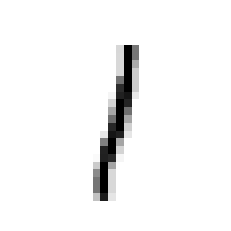

In [19]:
plot_image(X_valid.iloc[1].values.reshape(28,28))

# Autoencoding Models for Denoising
This chapter will be about two denoising autoencoder structures and their different ways of building such an architecture to reduce noise in data. The results of these models will be shown in the next chapter "Results - Denoising Autoencoders".

Basically an autoencoder architecture includes two seperate models, the encoder and the decorder. In the neuron point of view they both have a rejuvenation which represents a need of information compression - keep only the realy relevant information and drop the less relevant information. Both models combined therefore need to recreate information artificially - the main idea of an autoencoder structure.

## First Model - Deep Denoising Autoencoder 
This model uses fully connected layers and a dropout layer to simulate the noising in the data, which it will be trained on in the later process. There is no convolutional layer or other structures used like in the model in the following chapter.

### Encoder Architecture

In [20]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")           # Codings
])

In [21]:
dropout_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


### Decoder Architecture

In [22]:
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [23]:
dropout_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


### Building the Model

In [24]:
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))

### Training and Logging -  Deep Denoising Autoencoder

#### Logging the Model (ML Flow)

In [25]:
#mlflow.tensorflow.autolog()

#### Training the Model

In [26]:
history = dropout_ae.fit(X_train_resh, X_train_resh, epochs= 10, validation_data=(X_valid_resh, X_valid_resh))

Epoch 1/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2242 - val_loss: 0.1742
Epoch 2/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1679 - val_loss: 0.1491
Epoch 3/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1543 - val_loss: 0.1407
Epoch 4/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1480 - val_loss: 0.1339
Epoch 5/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1436 - val_loss: 0.1312
Epoch 6/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1406 - val_loss: 0.1311
Epoch 7/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1379 - val_loss: 0.1278
Epoch 8/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1356 - val_loss: 0.1261
Epoch 9/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1337 - val_loss: 0.1223
Epoch 10/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1321 - val_loss: 0.1204

#### Losses
The question is: "How good does the model reconstruct the given features/information". So there is no prediction of some label value! The model "predicts" (or better) reconstruct its input values as good as it can.

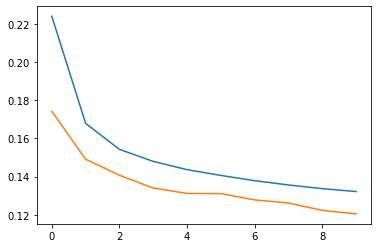

In [27]:
# Getting in touch with the model statistics 
# shows the available keys in models history:  print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Second Model - Convolutional Denoising Autoencoder
The second model is built on a convolutional structure. It uses several Conv2D layers in combinations with MaxPool2D layers to build the base structure. Instead of a Dropout layer to create noise  in the data (like the model one version) this time a GaussianNoise layer is used.

### Convolutional Encoder Architecture  

In [28]:
conv_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape = [28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size=3, activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=4),
    keras.layers.Dense(392, activation="relu")           # Codings
])

In [29]:
conv_encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 3, 3, 392)         12936     
Total params: 17,736
Trainable params: 17,736
Non-trainable params: 0
__________________________________________________

### Convolutional Decoder Architecture

In [30]:
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",activation="selu", input_shape=[3, 3, 392]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    keras.layers.Reshape([28, 28, 1])
])

In [31]:
conv_decoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 32)          112928    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 117,697
Trainable params: 117,697
Non-trainable params: 0
_________________________________________________________________


### Building the Model - Deep Convolutional Denoising Autoencoder

In [32]:
conv_denoising_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))

In [33]:
conv_denoising_ae.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 3, 3, 392)         17736     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28, 1)         117697    
Total params: 135,433
Trainable params: 135,433
Non-trainable params: 0
_________________________________________________________________


### Training and Logging - Deep Convolutional Denoising Autoencoder

#### Training the Model

In [34]:
history = conv_denoising_ae.fit(X_train_resh_ch, X_train_resh_ch, epochs= 10, validation_data=(X_valid_resh_ch, X_valid_resh_ch))


Epoch 1/10
880/880 [==============================] - 11s 12ms/step - loss: 0.1842 - val_loss: 0.1113
Epoch 2/10
880/880 [==============================] - 10s 12ms/step - loss: 0.1075 - val_loss: 0.1000
Epoch 3/10
880/880 [==============================] - 10s 12ms/step - loss: 0.0982 - val_loss: 0.0936
Epoch 4/10
880/880 [==============================] - 11s 12ms/step - loss: 0.0935 - val_loss: 0.0921
Epoch 5/10
880/880 [==============================] - 10s 12ms/step - loss: 0.0909 - val_loss: 0.0884
Epoch 6/10
880/880 [==============================] - 10s 12ms/step - loss: 0.0889 - val_loss: 0.0872
Epoch 7/10
880/880 [==============================] - 10s 12ms/step - loss: 0.0874 - val_loss: 0.0906
Epoch 8/10
880/880 [==============================] - 11s 12ms/step - loss: 0.0863 - val_loss: 0.0856
Epoch 9/10
880/880 [==============================] - 10s 12ms/step - loss: 0.0855 - val_loss: 0.0832
Epoch 10/10
880/880 [==============================] - 11s 12ms/step - loss: 0.084

In [35]:
# saving model for weight using in later process
conv_denoising_ae.save('conv_denoising_ae')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: conv_denoising_ae\assets


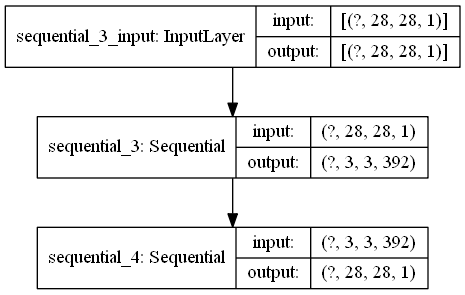

In [36]:
# Probably not working on Kaggle
plot_model(conv_denoising_ae, 'conv_autencoder.png', show_shapes=True)

# Results - Denoising Autoencoders
The structure of the "Results" chapter will in first place visualize the results of the different models (First Model - Deep Denoising Autoencoder and Second Model - Convolutional Denoising Autoencoder) by showing the origin digit and the reconstructed one without any noised data input. This is followed by a noised data test where a noised digit represents the input into the model and and a denoised, reconstructed one its result ("prediction").

## Results - Deep Denoising Autoencoder

### Origin Digit

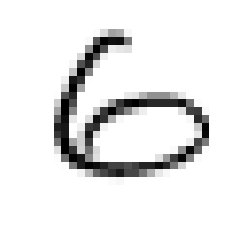

In [37]:
plot_image(X_valid_resh[10])

### ("Predicted") Reconstructed digit

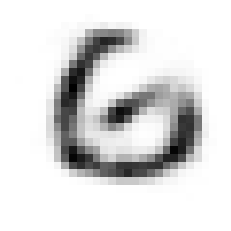

In [38]:
testimage = X_valid_resh[10].reshape(1, 28, 28)     # single image prepared for the test (reshape)
plot_image(dropout_ae.predict(testimage)[0, :, :])  # needed to extract the second and third array of the three dimensional tensor struc for printing the image

### Showing Multi Results

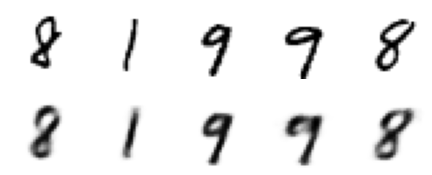

In [39]:
show_reconstructions(dropout_ae, X_valid_resh)

### Using Noised Images

#### Creating Noisy Data


In [40]:
new_images = X_test[5:10]
new_images = reshape_images(new_images)
noisy_images = new_images + np.random.randn(5,28,28) *0.1

#### Origin Number


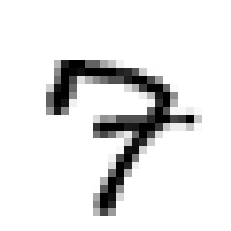

In [41]:
idx_testnumber = 0      # Index of test digit for the next plottings 
plot_image(new_images[idx_testnumber])

#### Noisy Digit

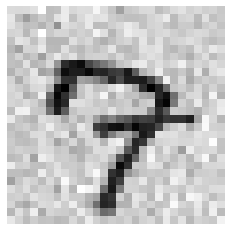

In [42]:
plot_image(noisy_images[idx_testnumber])

#### Denoised Digit

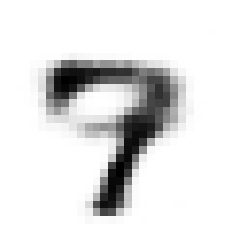

In [43]:
# Very Important ! added a new axis according to the models batch based behavior
plot_image(dropout_ae.predict(noisy_images[np.newaxis ,idx_testnumber]).reshape(28,28)) 

#### Multiple Digits in Comparision

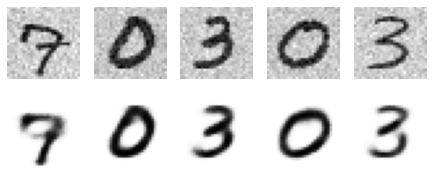

In [44]:
show_reconstructions(dropout_ae, noisy_images)

## Results - Convolutional Denoising Autoencoder

### Using Noised Images

#### Creating Noisy Data

In [45]:
new_images_conv = X_test[5:10]
new_images_conv = reshape_conv_images(new_images_conv)
noisy_images_conv = new_images_conv + np.random.randn(5, 28, 28, 1) *0.1

#### Origin Digit


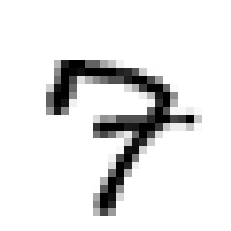

In [46]:
idx_testnumber = 0      # Index of test number for the next plottings 
plot_image(new_images_conv[idx_testnumber])

#### Noisy Digit

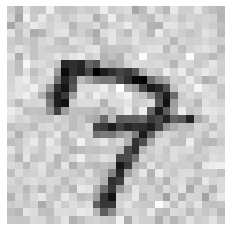

In [47]:
plot_image(noisy_images_conv[idx_testnumber])

#### Denoised Digit

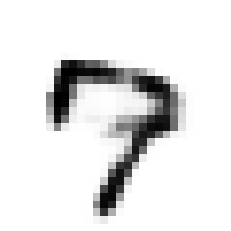

In [48]:
# Very Important ! added a new axis according to the models batch based behavior
plot_image(conv_denoising_ae.predict(noisy_images_conv[np.newaxis ,idx_testnumber]).reshape(28,28))

#### Multiple Digits in Comparision

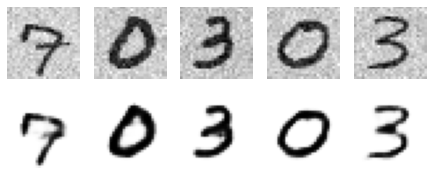

In [49]:
show_reconstructions(conv_denoising_ae, noisy_images_conv)

# Third Model - Unsupervised Pre-Training for Supervised Training
This chapter is about a third model whose topic is to predict a digit shown on a MNIST image. Basically, the architecture represents the way of using unsupervised pre-training for projects that do not have enough training data to train the model properly. In this part layers from the already trained Convolutional Denoising Autoencoder (second model) will be used to build a classification prediction model.

In [50]:
# Loading untouched model weights 
# Doing this for the reason that model weights are modified not only for a specifically created model object (that's what I was recognizing), but for the stored object in the cache.
# Therefore I load here the model new from storage to be capable of running multiple new model trainings without any influence on previous runs (make this training deterministic)
conv_denoising_ae_clone = tf.keras.models.load_model("conv_denoising_ae")

In [51]:
ae_model_id = 0 # 0 for encorder / 1 for decorder
layerscount = 5 # how many layers of the model ...


new_model = keras.models.Sequential(conv_denoising_ae_clone.layers[ae_model_id].layers[:layerscount])
new_model.trainable =True  # Setting it on True to sepcificly set them on False afterwards  

In [52]:
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
Total params: 4,800
Trainable params: 4,800
Non-trainable params: 0
_________________________________________________________________


### Making the Layers Trainable / Not-Trainable
The already trained layers which have been trained in the unsupervised way above need to be frozen so that only the new layers for the new topic (classification) can be trained.

In [53]:
# Make the layers not trainable 
for layer in new_model.layers[:layerscount -1 ]:              # last layer still be trainable
    layer.trainable = False
    print(f"Layer '{layer.name}' is Trainable = {layer.trainable}")

Layer 'gaussian_noise' is Trainable = False
Layer 'conv2d' is Trainable = False
Layer 'max_pooling2d' is Trainable = False
Layer 'conv2d_1' is Trainable = False


Adding the layers for the new topic

In [54]:
new_model.add(keras.layers.Flatten())
new_model.add(keras.layers.Dense(10, activation="softmax"))

Viewing final layers-construction and its trainabilaties

In [55]:
for layer in new_model.layers:
    print(f"Layer '{layer.name}' trainable state = {layer.trainable}")

Layer 'gaussian_noise' trainable state = False
Layer 'conv2d' trainable state = False
Layer 'max_pooling2d' trainable state = False
Layer 'conv2d_1' trainable state = False
Layer 'max_pooling2d_1' trainable state = True
Layer 'flatten_1' trainable state = True
Layer 'dense_5' trainable state = True


In [56]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(), metrics=["accuracy"]) ##keras.optimizers.SGD(learning_rate=0.0003)

In [57]:
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

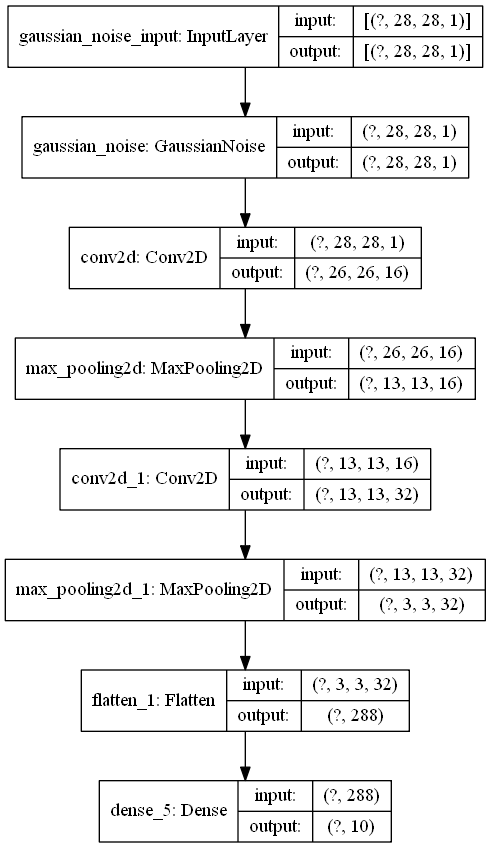

In [58]:
plot_model(new_model, 'autencoder_base_w_classifier.png', show_shapes=True)

In [59]:
new_model.save('class_net_01')

INFO:tensorflow:Assets written to: class_net_01\assets


## Creating Training Data for Unsupervised Pre-Training Model
In this part 500 data points will be created for training a normal backpropagation model based on the unsupervised pre-trained model.

Additionally, the remaining data points will be used for testing the model's accuracy.

In [60]:
#DEBUG TODO: Using the reshape_conv_image function here or better the already converted dataframe set.

X_train_pret_resh_500 = X_train_resh_ch[:500]
X_valid_pret_resh_500 = X_valid_resh_ch[:500]

X_valid_pret_resh_r = X_valid_resh_ch[500:]   # Choosing the last 500 digits for testing unknown, untrained data


y_train_pretrained_500 = y_train_resh[:500]
y_valid_pretrained_500 = y_valid_resh[:500]

y_valid_pretrained_r = y_valid_resh[500:]

## Training and Logging

#### Tensorboard Logging

In [61]:
# Tensorboard logging structure function
root_logdir = "../../tensorboard-logs"

def get_run_logdir(root_logdir, project):
    '''
    Returns logdir to the Tensorboard log for a specific project.

            Parameters:
                    root_logdir (str) : basic logdir from Tensorboard
                    project (str): projectname that will be logged in TB

            Returns:
                    os.path (str): Path to the final logdir
    '''
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    project_logdir = os.path.join(root_logdir,project)
    return os.path.join(project_logdir, run_id)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=get_run_logdir(root_logdir,"autoencoding_mnist"), histogram_freq=1)


#### Training the Pre-Trained Model

In [62]:
history_pretrainted = new_model.fit(X_train_pret_resh_500,y_train_pretrained_500 ,epochs=20, \
                                        validation_data=(X_valid_pret_resh_500,y_valid_pretrained_500), \
                                        callbacks=tensorboard_callback
                                    )


Epoch 1/20
 1/16 [>.............................] - ETA: 0s - loss: 6.4475 - accuracy: 0.0312WARNING:tensorflow:From D:\anaconda3\envs\wingpuflake_keras\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
16/16 [==============================] - 0s 14ms/step - loss: 4.1023 - accuracy: 0.1200 - val_loss: 2.6894 - val_accuracy: 0.1720
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 2.2778 - accuracy: 0.2640 - val_loss: 1.7826 - val_accuracy: 0.4280
Epoch 3/20
16/16 [==============================] - 0s 6ms/step - loss: 1.5390 - accuracy: 0.4700 - val_loss: 1.2647 - val_accuracy: 0.6100
Epoch 4/20
16/16 [==============================] - 0s 6ms/step - loss: 1.1160 - accuracy: 0.6060 - val_loss: 0.9891 - val_accuracy: 0.7000
Epoch 5/20
16/16 [==============================] - 0s 6ms/step 

### Loss Plotting

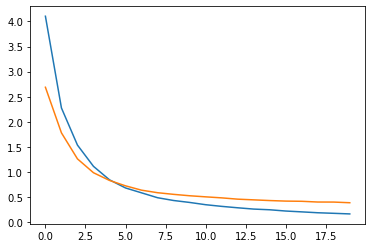

In [63]:
plt.plot(history_pretrainted.history['loss'])
plt.plot(history_pretrainted.history['val_loss'])

## Predicting the Digit on a Pre-Trained Autoencoder Based Model

The prediction test on unseen data with the pre-trained autoencoder based model will be used with the validation dataset. The model is trained on the first 500 digits from the train set and validated by the first 500 digits on the validation set. There are still enough data in the validation set (and in the train dataset but it sounds better to use the validation set for) to test the model with unseen data (in total 13.360 digits).

First there is a visualized test, where the test digit and its prediction will be printed.

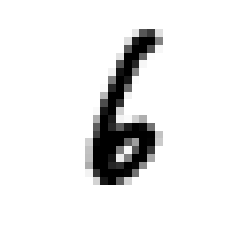

In [64]:
idx_testnumber_cls_ae = 8      # Index of test number for the next plottings 
plot_image(X_valid_pret_resh_r[idx_testnumber_cls_ae])

In [65]:
print(f"Prediction based on the picture above: {np.argmax(new_model.predict(X_valid_pret_resh_r[np.newaxis, idx_testnumber_cls_ae]))}")
print(f"Probability of the Prediction: {new_model.predict(X_valid_pret_resh_r[np.newaxis, idx_testnumber_cls_ae])}")

Prediction based on the picture above: 6
Probability of the Prediction: [[1.6106494e-03 1.7411570e-01 8.1677791e-03 3.9541041e-03 9.1888852e-02
  2.6036915e-03 6.9009292e-01 1.5061849e-04 4.7319308e-03 2.2683796e-02]]


Following will be determine the accuracy on the remaining validation dataset of 13.360 digits and shows the overall accuracy of the model after pre-training and classification training.

In [66]:
y_val_pred_r = new_model.predict(X_valid_pret_resh_r)
y_val_pred_r = y_val_pred_r.argmax(axis = 1)[:,None]

In [67]:
from sklearn.metrics import accuracy_score
acc_score_val = accuracy_score(y_valid_pretrained_r, y_val_pred_r)

print(f"Unsupervised pre-trained model, trained on 500 digits, predicting {y_val_pred_r.shape[0]:} digits with only 20 epochs trained with an accuracy of: {acc_score_val}")

Unsupervised pre-trained model, trained on 500 digits, predicting 13360 digits with only 20 epochs trained with an accuracy of: 0.8820359281437126
